<h1><center>Analyzing Trends from 18,393 Pitchfork Music Reviews</center></h1>
<h2><center>Leo Jagid and Nicholas Kristy</center></h2>
<a href="link" style="text-align: center">
<img src="pitchfork-logo2.png" alt="pitchfork" width="600" height="400" align="center"></a>

## Introduction 
The goal of this tutorial is to take data from over 18,000 album reviews written between 1999 and 2017 from [Pitchfork](https://pitchfork.com/), a popular and well-respected music publication started in 1995, and see if we can use it to answer a few questions. More specifically, we are first going to examine pitchfork review scores in general: What does the overall score distribution look like? Are the reviews generally strict or fairly lenient? Once we have a better idea of what review scores actually mean, we will look at individual artists and use their album scores to rank them to see who Pitchfork thinks are the best and worst artists they have reviewed. 

After we acquire a ranked list of artists, we aim to prove or disprove a common theory among music fans: is an artist's old music almost always better than their newer material? We also plan on using the scikit-learn library to see if we can predict an album's score based on artist and genre. We will take the last few years of reviews to use as a test set for our machine learning model.

## Data Acquisition
Our [data](https://www.kaggle.com/nolanbconaway/pitchfork-data) comes in the form of an sqlite file that was posted to [Kaggle](https://www.kaggle.com/) and was created by data scientist Nolan Conaway. We used simple sqlite queries along with pandas to get all of the pertinent information into one easy-to-understand data frame. We needed to merge data taken from different tables within the sqlite file, but this was made easy by Conaway who made sure to put a unique review id number as a column in every table. 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
# Loading the SQLite database containing the reviews
sqlite_file = 'music_data.sqlite'
conn = sqlite3.connect(sqlite_file)

# SQLite queries that select the information we want to look at from their respective tables
artist_query = "SELECT artist, reviewid FROM artists"
artists = pd.read_sql(artist_query, conn)

genre_query = "SELECT genre, reviewid FROM genres"
genres = pd.read_sql(genre_query, conn)

review_query = "SELECT reviewid, title, score FROM reviews"
reviews = pd.read_sql(review_query, conn)

years_query = "SELECT year, reviewid FROM years"
years = pd.read_sql(years_query, conn)

# These next three lines merge all of the data that we collected together to create one easy-to-read data frame.
combined1 = pd.merge(artists, reviews, on = 'reviewid')
combined2 = pd.merge(combined1, years, on = 'reviewid')
combined3 = pd.merge(combined2, genres, on = 'reviewid')
combined3.head(10)

,artist,reviewid,title,score,year,genre
0,massive attack,22703,mezzanine,9.3,1998.0,electronic
1,krallice,22721,prelapsarian,7.9,2016.0,metal
2,uranium club,22659,all of them naturals,7.3,2016.0,rock
3,kleenex,22661,first songs,9.0,2016.0,rock
4,liliput,22661,first songs,9.0,2016.0,rock
5,taso,22725,new start,8.1,2016.0,electronic
6,various artists,22722,insecure (music from the hbo original series),7.4,2016.0,None
7,little simz,22704,stillness in wonderland,7.1,2016.0,rap
8,yotam avni,22694,tehillim,7.0,2016.0,electronic
9,brian eno,22714,reflection,7.7,2017.0,experimental


## Tidying the Data
Although this merged data frame technically contains all the information we need to analyze, there is still some work to be done. Firstly, we have decided to remove all rows (where each row represents a single review) that do not have a year, score, genre, or artist name. We chose to remove those lines entirely because we plan on using artists' scores to rank them and without any of those necessary pieces of information, doing so becomes much more difficult. We also decided to remove any review in which the artist is listed as "various artists" because there is no way to know within the Kaggle data set which artists worked on the album. Next we sorted the rows by artist and year so that each artist's reviews were together and sorted by year. Originally, years were of the float data type but we did not see much value in that so we switched them to integers. Finally, we noticed that for some reason, there were a few repeated review ids that represented the same review, so we removed all duplicates. This left us with a much cleaner dataset that only contained data that we intend on using. 

In [3]:
# Remove rows with null values for score, year, or genre
tidy_df = combined3[combined3['score'].notnull()]
tidy_df = tidy_df[tidy_df['year'].notnull()]
tidy_df = tidy_df[tidy_df['genre'].notnull()]

# Removes reviews that do not have an artist or that have 'various artists'
tidy_df = tidy_df[tidy_df['artist'] != '']
tidy_df = tidy_df[tidy_df['artist'] != 'various artists']

# Sort the data frame by artist and then year
tidy_df = tidy_df.sort_values(by = ['artist', 'year'])

# Changing the year column from float to int data type
tidy_df = tidy_df.astype({'year': 'int32'})

# Getting rid of duplicate review ids
tidy_df = tidy_df.drop_duplicates(subset=['reviewid'])
tidy_df.head(10)

,artist,reviewid,title,score,year,genre
20113,!!!,1765,split ep,6.0,1999,rock
19574,!!!,1764,louden up now,7.0,2004,rock
15071,!!!,9956,myth takes,8.0,2007,rock
9128,!!!,14811,"jamie, my intentions are bass ep",6.8,2010,rock
9428,!!!,14570,"strange weather, isn't it?",6.9,2010,rock
5298,!!!,17954,thr!!!er,6.0,2013,rock
1788,!!!,21182,as if,6.9,2015,rock
23198,-ziq,8321,tango n' vectif,9.4,1993,electronic
20932,-ziq,8326,bilious paths,7.9,2003,electronic
4877,-ziq,18307,somerset avenue tracks (1992-1995),8.0,2013,electronic


## Examining the Distribution of Review Scores
Before getting into ranking artists, we felt that it would be useful to look into the distribution of scores from every review in our data set. This allows us to see pitchfork review trends over time and answer questions like: How strict is the pitchfork review criteria? Does older music generally do better than newer music?

To start this analysis, we created a scatter plot of review score vs year:

<AxesSubplot:xlabel='year', ylabel='score'>

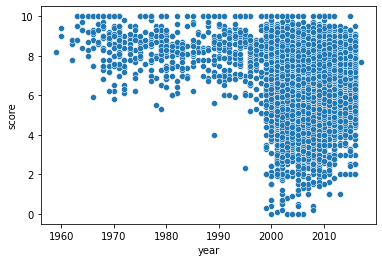

In [4]:
sns.scatterplot(x = tidy_df['year'], y = tidy_df['score'])

This scatterplot reveals a glaring issue with our data which is that music that was released before the late 1990s tended to be rated much higher than music released afterwards. Pitchfork was founded in 1995, so all music they have reviewed that was released before then had already been around for years. They tend to be much higher because instead of reviewing a wide variety of older music after their founding, pitchfork reviewers were more likely to select well known or critically acclaimed albums to review.

To correct this issue, we made the decision to ignore all reviews for albums that came out prior to 1995:

<AxesSubplot:xlabel='year', ylabel='score'>

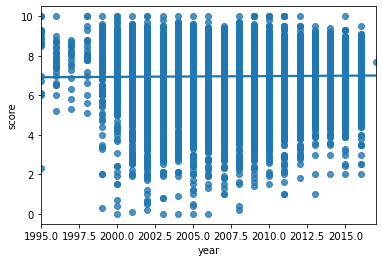

In [5]:
# Remove all albums with release year less than 1995
tidy_df = tidy_df[tidy_df['year'] > 1994]

# Plot new scatterplot
sns.regplot(x = tidy_df['year'], y = tidy_df['score'])

The new scatterplot is much more reasonable. Next we will plot the distribution and a box-plot to perform some basic statistical analysis.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


mean: 6.96790764980595
median: 7.2
standard deviation: 1.2807258264465482


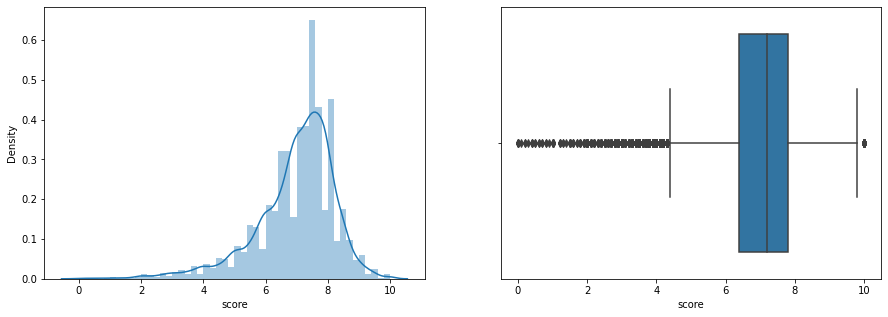

In [6]:
# Prepare spots for two plots
fig, ax = plt.subplots(1,2, figsize=(15, 5))
# Plot the range of scores using a modified histogram plot
sns.distplot(tidy_df['score'], ax = ax[0])
# Plot the range of scores using a box plot
sns.boxplot(tidy_df['score'], ax = ax[1])
# Calculate and print out the mean, median, and standard deviation of the data
mean = np.mean(tidy_df['score'])
median = np.median(tidy_df['score'])
standard_dev = np.std(tidy_df['score'])
print("mean: " + str(mean))
print("median: " + str(median))
print("standard deviation: " + str(standard_dev))

By looking at the distribution plot, it is clear that review scores tend to be on the higher side, with an average score of 7.2. Also, the mean value is lower than the median, which is evidence of a slight negative skew.

## Defining "Best" and "Worst" Artists
Quality of music is, in most cases, a highly subjective topic of discussion. However, for the sake of this investigation, it is necessary to come up with some sort of metric using the pitchfork data set to determine who the best and worst artists are. To come up with these rankings, we have decided to use average album score. However, we need to do a little more work before calculating the averages. First, we need to create a new column for our data frame with the number of albums that has been reviewed by pitchfork by each artist. Then, we elected to remove all artists who have not had more than 2 albums reviewed between 1995 and 2017 because, in our opinion, one or two albums is not enough of a sample size to be considered a great or not-so-great artist. After these steps are taken, the average for each artist is calculated by summing the scores of their albums and then dividing by the number of albums. Those scores are then appended onto our existing DataFrame as a new column.

In [7]:
# Create a dictionary where the keys is artist name and the value is 
# the number of albums that have been reviewed by Pitchfork within the 1999-2017 window 
num_albums_dict = dict()
for i, artist in tidy_df['artist'].items():
    if not artist in num_albums_dict:
        num_albums_dict[artist] = 1
    else:
        num_albums_dict[artist] += 1

# Create a 'number of albums' column for each artist to make avg calculation simpler
album_ct_col = []
for i, row in tidy_df.iterrows():
    album_ct_col.append(num_albums_dict[row['artist']])

tidy_df['num_albums'] = album_ct_col

# Get rid of artists that have had fewer than 3 albums reviewed.
tidy_df = tidy_df[tidy_df['num_albums'] > 2]

# Calculate average by summing each artists score and then dividing by number of albums
avg_scores = []
curr_avg = 0
curr_artist = tidy_df['artist'][0]
for i, row in tidy_df.iterrows():
    if row['artist'] == curr_artist:
        curr_avg += row['score'] / row['num_albums']
    else:
        avg_scores.append(curr_avg)
        curr_avg = row['score'] / row['num_albums']
        curr_artist = row['artist']

avg_scores.append(curr_avg)

# Create the averages column using the previous calculations and adding it to the data frame.
averages = []
curr_artist = tidy_df['artist'][0]
index = 0
for i, row in tidy_df.iterrows():
    if row['artist'] == curr_artist:
        averages.append(avg_scores[index])
    else:
        curr_artist = row['artist']
        index += 1
        averages.append(avg_scores[index])
tidy_df['avg_score'] = averages
tidy_df.head()

,artist,reviewid,title,score,year,genre,num_albums,avg_score
20113,!!!,1765,split ep,6.0,1999,rock,7,6.8
19574,!!!,1764,louden up now,7.0,2004,rock,7,6.8
15071,!!!,9956,myth takes,8.0,2007,rock,7,6.8
9128,!!!,14811,"jamie, my intentions are bass ep",6.8,2010,rock,7,6.8
9428,!!!,14570,"strange weather, isn't it?",6.9,2010,rock,7,6.8


## Ranking Artists
Now that we have a way to measure an artist's quality, it is time to rank them. To do this, we created a new data frame and set it to a copy of the tidy_df, removed all duplicate artists so that each artist had only one row, dropped columns that we do not need ('reviewid', 'title', 'score', 'year'), and then sorted the rows by avg_score.

In [8]:
# Sort by avg score to get best and worst artists
artist_ranking = tidy_df.copy()
artist_ranking = artist_ranking.drop_duplicates(subset=['artist'])
artist_ranking = artist_ranking.drop(columns=['reviewid', 'title', 'score', 'year'])
artist_ranking = artist_ranking.sort_values(by = ['avg_score'])
artist_ranking

,artist,genre,num_albums,avg_score
18294,louis xiv,rock,3,2.833333
21647,the warlocks,rock,4,3.025000
18194,the bravery,rock,3,3.133333
23849,har mar superstar,rock,3,3.233333
23880,ok go,rock,3,3.400000
...,...,...,...,...
23664,max tundra,folk/country,3,9.000000
10863,girls,rock,3,9.033333
23159,the velvet underground,rock,4,9.050000
24024,gas,electronic,3,9.233333


Next, we get the 20 best and 20 worst artists according to our metrics.

Here are the top 20:

In [9]:
top_20 = artist_ranking.tail(20)
top_20 = top_20.sort_values(by = ['avg_score'], ascending = False)
top_20

,artist,genre,num_albums,avg_score
23295,john coltrane,jazz,3,9.500000
24024,gas,electronic,3,9.233333
23159,the velvet underground,rock,4,9.050000
10863,girls,rock,3,9.033333
23664,max tundra,folk/country,3,9.000000
16264,the replacements,rock,3,8.966667
9815,tame impala,rock,3,8.933333
24004,sleater-kinney,rock,5,8.860000
7987,kendrick lamar,rap,4,8.850000
12959,fleet foxes,rock,3,8.833333


And here are the bottom 20:

In [10]:
bottom_20 = artist_ranking.head(20)
bottom_20

,artist,genre,num_albums,avg_score
18294,louis xiv,rock,3,2.833333
21647,the warlocks,rock,4,3.025000
18194,the bravery,rock,3,3.133333
23849,har mar superstar,rock,3,3.233333
23880,ok go,rock,3,3.400000
16922,richard ashcroft,rock,3,3.433333
21053,liz phair,rock,4,3.550000
22874,matt pond pa,rock,4,3.575000
19297,keane,rock,4,3.600000
20960,the dandy warhols,rock,5,3.620000


## Plotting Best and Worst Artists
Now that we have our artist rankings, we can make a few plots to see if their music improves or declines in quality over time. Using the information we get from the plots, we should be able to answer the question of whether or not an artist's older material is usually better than their newer albums.

We have the necessary data frames to make the plots, but we need to create another column that numbers the albums for each artist. We need to do this because to make the scatter plots we will be converting our data frame to a pivot table and if we use years as the index instead of album number, there will be duplicate index-artist pairs if an artist released more than one album in a year which will give us errors.

In [11]:
# Create an 'album number' column to list the release order of an artist's albums
tidy_df = tidy_df.sort_values(by = ['artist'])
album_numbers = []
curr_artist = tidy_df.reset_index()['artist'][0]
curr_album_num = 0
for i, row in tidy_df.iterrows():
    if row['artist'] == curr_artist:
        curr_album_num += 1
        album_numbers.append(curr_album_num)
    else:
        curr_album_num = 1
        album_numbers.append(curr_album_num)
        curr_artist = row['artist']

# Add the column to the data_frame
tidy_df['album_num'] = album_numbers
tidy_df.head()

,artist,reviewid,title,score,year,genre,num_albums,avg_score,album_num
20113,!!!,1765,split ep,6.0,1999,rock,7,6.8,1
19574,!!!,1764,louden up now,7.0,2004,rock,7,6.8,2
15071,!!!,9956,myth takes,8.0,2007,rock,7,6.8,3
9128,!!!,14811,"jamie, my intentions are bass ep",6.8,2010,rock,7,6.8,4
9428,!!!,14570,"strange weather, isn't it?",6.9,2010,rock,7,6.8,5


<AxesSubplot:xlabel='album_num', ylabel='score'>

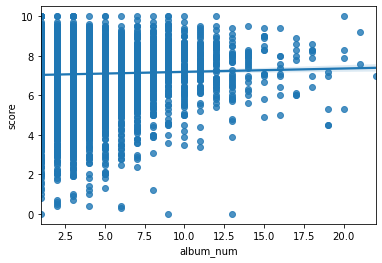

In [12]:
sns.regplot(x = tidy_df['album_num'], y = tidy_df['score'])

According to the above plot, there actually seems to be a very slight upward trend towards artists with more albums, meaning that artist's newer material tends to be slightly better or the same as their old material. We speculated that there might be many reasons for this. Perhaps only the most successful artists create more than a few albums, or maybe quality increases or steadies over time. The best conclusion we came to is that we might need a smaller dataset to analyze because the range of artists and their number of albums is enormous.

In the following two cells, we create and display new DataFrames for the highest and lowest ranking artists to be used for analyzation.

In [13]:
top_20_df = tidy_df.copy()
# Only selecting rows where artists are in the top 20
top_20_df = top_20_df[top_20_df['artist'].isin(top_20['artist'])]
top_20_df = top_20_df.sort_values(by = ['avg_score'], ascending = False)
top_20_df.head()

,artist,reviewid,title,score,year,genre,num_albums,avg_score,album_num
1652,john coltrane,21158,a love supreme: the complete masters,10.0,2015,jazz,3,9.500000,3
23295,john coltrane,1550,the olatunji concert: the last live recording,10.0,2001,jazz,3,9.500000,1
3040,john coltrane,19522,offering: live at temple university,8.5,2014,jazz,3,9.500000,2
71,gas,22555,box,9.5,2016,electronic,3,9.233333,3
12967,gas,11582,nah und fern,9.2,2008,electronic,3,9.233333,2


In [14]:
bottom_20_df = tidy_df.copy()
# Only selecting rows where artists are in the bottom 20
bottom_20_df = bottom_20_df[bottom_20_df['artist'].isin(bottom_20['artist'])]
bottom_20_df = bottom_20_df.sort_values(by = ['avg_score'])
bottom_20_df.head()

,artist,reviewid,title,score,year,genre,num_albums,avg_score,album_num
18294,louis xiv,4981,the best little secrets are kept,1.2,2005,rock,3,2.833333,1
13573,louis xiv,11106,slick dogs and ponies,2.5,2008,rock,3,2.833333,3
18390,louis xiv,4980,illegal tender ep,4.8,2005,rock,3,2.833333,2
11332,the warlocks,13049,the mirror explodes,3.4,2009,rock,4,3.025000,4
17436,the warlocks,8586,surgery,1.7,2005,rock,4,3.025000,2


Now we are able to convert these data frames to pivot tables and create our scatter plots and spaghetti plots:

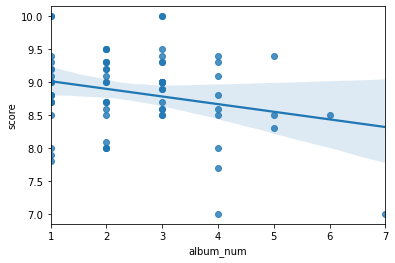

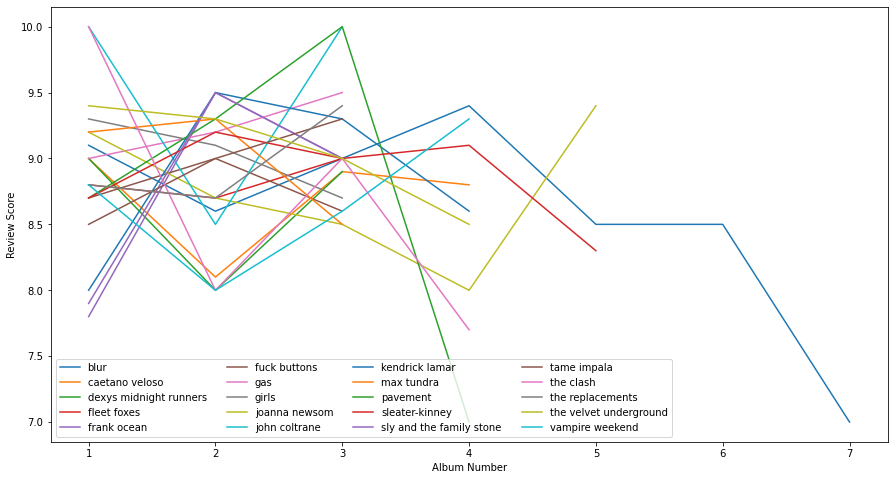

In [15]:
# Choose only necessary columns
top_20_df = top_20_df[['artist','album_num','score']]
# Plot regression of number of albums vs score
sns.regplot(x = top_20_df['album_num'], y = top_20_df['score'])
# Reorder the DataFrame for the creation of the spaghetti plot
top_20_df = top_20_df.pivot(index = 'album_num', columns = 'artist', values = 'score')
# Spaghetti plot showing scores over album number for each artist
top_20_df.plot(figsize = (15,8))
plt.xlabel('Album Number')
plt.ylabel('Review Score')
plt.legend(ncol = 4)

In the first plot, there seems to be a downward trend of about half a point as the number of albums increases. Looking at the individual data points, this seems to make sense, though there are way fewer artists that release more than 4 albums. The second plot shows the trends for individual artists.

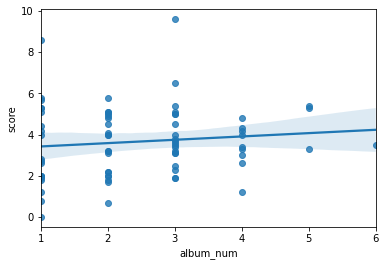

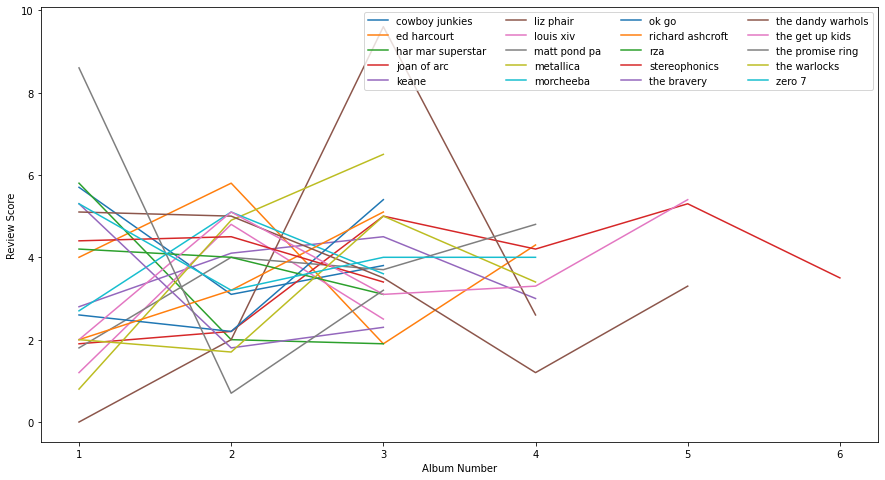

In [16]:
# Choose only necessary columns
bottom_20_df = bottom_20_df[['artist','album_num','score']]
# Plot regression of number of albums vs score
sns.regplot(x = bottom_20_df['album_num'], y = bottom_20_df['score'])
# Reorder the DataFrame for the creation of the spaghetti plot
bottom_20_df = bottom_20_df.pivot(index = 'album_num', columns = 'artist', values = 'score')
# Spaghetti plot showing scores over album number for each artist
bottom_20_df.plot(figsize = (15,8))
plt.xlabel('Album Number')
plt.ylabel('Review Score')
plt.legend(ncol = 4)

In the case of the bottom 20 artists, there is a slight upward trend of about half a point. The individual points back this up if one looks at the groupings per album number. The second plot shows the trends for individual artists.

## Genre Score Calculation
The next step is to calculate something we termed a 'genre score'. A genre score is similar to an artist's average score - it is calculated by taking the total score from reviews of a certain genre and dividing by the number of reviews in that genre. The genre scores will be used in analysis besides the plotting of the next cell.

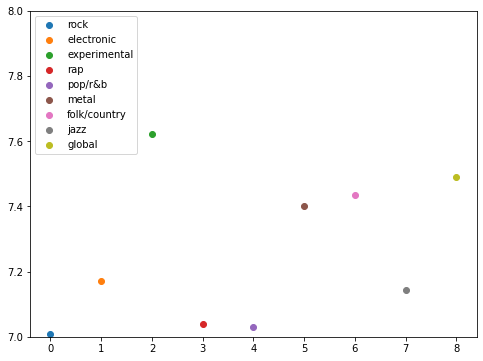

In [17]:
genre_data = tidy_df.sort_values(by='genre')
# Create DataFrame to store score for each genre
scores = [['rock', 0], ['electronic', 0], ['experimental', 0], ['rap', 0], ['pop/r&b', 0], \
          ['metal', 0], ['folk/country', 0], ['jazz', 0], ['global', 0]]
genre_scores = pd.DataFrame(scores, columns = ['genre', 'score'])
# Create Dictionary to store number of reviews for each genre
num_genres = {'rock':0, 'electronic':0, 'experimental':0, 'rap':0, 'pop/r&b':0, 'metal':0, \
              'folk/country':0, 'jazz':0, 'global':0}
# Sum the total scores and total number of items per genre
for i, row in genre_data.iterrows():
    genre_scores.loc[row['genre'] == genre_scores['genre'], 'score'] += row['score']
    num_genres[row['genre']] += 1
# Calculate the 'genre score', a.k.a. the average score of the genre
for genre in num_genres.keys():
    genre_scores.loc[genre_scores['genre'] == genre, 'score'] /= num_genres[genre]
# Retrieve calculated scores, insert into another Dictionary
scores_dict = {'rock':0, 'electronic':0, 'experimental':0, 'rap':0, 'pop/r&b':0, 'metal':0, \
              'folk/country':0, 'jazz':0, 'global':0}
for i, row in genre_scores.iterrows():
    scores_dict[row['genre']] = row['score']
# Create a new column for tidy_df that will add the correct genre score
# to every review in the DataFrame
arr = []
for i, row in tidy_df.iterrows():
    arr.append(scores_dict[row['genre']])
tidy_df['genre_score'] = arr
# Scatter plot of every genre and respective score
plt.figure(figsize=(8, 6))
plt.ylim(7, 8)
for i, row in genre_scores.iterrows():
    plt.scatter(i, row['score'], label = row['genre'])
plt.legend(loc = 2)

This plot displays the genre scores for each genre. Experimental seems to be the highest-ranking genre, followed by the global and folk/country genres.

## Standardized Artist Score
The average score of an artist is a piece of information we were interested in using, but it was not standardized across all artists - only for each artist individually. To solve this, another column was created where each artist's average score was divided by the total number of artists. This could not be done earlier because some scores were weighted unevenly by factors such as the number of albums produced.

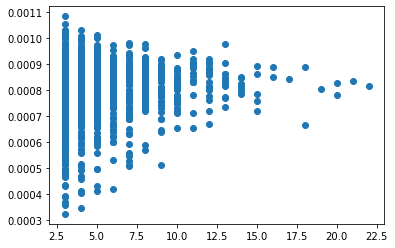

In [18]:
artist_data = tidy_df.copy()
# Select on necessary columns
artist_scores = pd.DataFrame(artist_data[['artist', 'num_albums', 'avg_score']])
# Create a standardized artist score - an average score across all artists
artist_scores['std_artist_score'] = artist_scores['avg_score'] / len(artist_scores.index)
# Add this new column to tidy_df
tidy_df['std_artist_score'] = artist_scores['std_artist_score']
# Select only uniques to be plotted
artist_scores = artist_scores.drop_duplicates(subset = ['artist'])
# Plot number of albums vs. avg score
plt.scatter(artist_scores['num_albums'], artist_scores['std_artist_score'])

This graph is very similar to our regression plot earlier. This makes sense since everything is pretty much the same, but standardized.

## Correlation Between Factors?
Finally, we were interested in knowing if the following factors impacted album scores: The number of albums, the genre score, or the standardized artist score. To do so, we set up a linear regression model and plotted the results using seaborn.residplot. The datasets are split up into training and testing sets, where the training set is the first 5,000 entries of the set and the testing set is the remaining values.

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

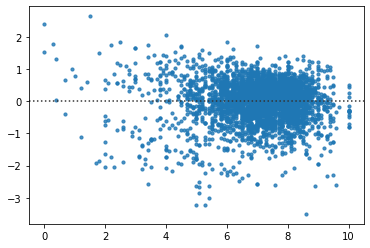

In [19]:
# Prepare X and y for use in the Linear Regression model
X = tidy_df[['num_albums', 'genre_score', 'std_artist_score']]
y = tidy_df['score']
# Separate into train and test sets
X_train = X[:5000]
X_test = X[5000:]
y_train = y[:5000]
y_test = y[5000:]
# Create model, predict
model = linear_model.LinearRegression()
model = model.fit(X_train,y_train)
coef = model.coef_
prediction = model.predict(X_test)
sns.residplot(y_test.values, prediction, scatter_kws={"s": 10})

As seen by the above plot, there does not seem to be any sort of correlation between the factors chosen and the score of an album. We suspect that there are likely many more factors that play into it, big and small, which can be very difficult to calculate. Is the time we live in that certain things are more impactful, is every artist more or less similar in some ways, or are the reviewers simply biased? The answers are unknown with just the results of our analysis.

## Conclusion
The analysis we conducted resulted in some interesting findings about the Pitchfork reviews dataset. Our first initial question was answered in the __Plotting Best and Worst Artists__ section. Based on the total dataset, there is not a trend of an artist's older music being better. We weren't sure if this was accurate, so we took two smaller datasets termed as the top 20 and bottom 20 artists of the list. Based on these datasets, there is only at most a half-point difference downwards and upwards in the top and bottom artist lists, respectively. Then, we looked to answer the second initial question: Are there quantifiable factors that impact an album's score? We calculated three factors - total number of albums, album score, and a standardized artist score - that ultimately had no correlation with an album's score. There should be a larger, more in-depth analysis of music reviews to truly understand the factors behind these ratings.